In [1]:
%run homework_modules.ipynb

NumPy GlobalMaxPool2d Output:
 [[[[1.5284473]]

  [[1.9217757]]

  [[1.9996144]]]


 [[[1.0241501]]

  [[1.474389 ]]

  [[1.3481047]]]]
PyTorch AdaptiveMaxPool2d Output:
 [[[[1.5284473]]

  [[1.9217757]]

  [[1.9996144]]]


 [[[1.0241501]]

  [[1.474389 ]]

  [[1.3481047]]]]

NumPy GlobalAvgPool2d Output:
 [[[[-0.42428303]]

  [[ 0.01439766]]

  [[ 0.3603322 ]]]


 [[[-0.27406132]]

  [[-0.1537225 ]]

  [[ 0.28056434]]]]
PyTorch AdaptiveAvgPool2d Output:
 [[[[-0.42428306]]

  [[ 0.01439767]]

  [[ 0.3603322 ]]]


 [[[-0.27406132]]

  [[-0.1537225 ]]

  [[ 0.28056437]]]]


<>:2: SyntaxWarning: invalid escape sequence '\g'
/var/folders/x8/7xjyf4q529105pmwvqd3cqw40000gn/T/ipykernel_55901/3092293347.py:2: SyntaxWarning: invalid escape sequence '\g'
  """


In [2]:
import numpy as np
#import torch
from torch.autograd import Variable
#import unittest
from torchvision.datasets import MNIST
import torchvision.transforms as T
import matplotlib.pyplot as plt

# 1 номер

In [4]:
def sgd(x, dx, config):

    
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            cur_x -=  config['learning_rate'] * cur_dx

# 2 номер

In [6]:
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
X, y = make_regression(n_samples=10000, n_features=10, n_informative=7, n_targets=3, random_state=2)
print(X.shape, y.shape)
train_X, test_X, train_Y, test_Y = train_test_split(X, y, test_size=0.25)

(10000, 10) (10000, 3)


In [7]:
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]

    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

In [8]:
class MultiOutputNN(Module):
    def __init__(self, in_features, num_outputs, hide_neurons):
        super(MultiOutputNN, self).__init__()
        self.model = Sequential()

        self.model.add(Linear(in_features, hide_neurons))
        self.model.add(BatchNormalization(hide_neurons)) 
        self.model.add(ReLU())
        self.model.add(Dropout(0.5)) 

        self.model.add(Linear(hide_neurons, hide_neurons // 2))
        self.model.add(BatchNormalization(hide_neurons // 2))
        self.model.add(ReLU())
        self.model.add(Dropout(0.5))

        self.model.add(Linear(hide_neurons // 2, hide_neurons // 4))
        self.model.add(BatchNormalization(hide_neurons // 4))
        self.model.add(ReLU())
        self.model.add(Dropout(0.5))

        self.model.add(Linear(hide_neurons // 4, num_outputs))
        self.criterion = MSECriterion()

    def forward(self, X):
        return self.model.updateOutput(X)
    def backward(self, gradOutput):
        return self.model.backward(None, gradOutput)
    def zeroGradParameters(self):
        self.model.zeroGradParameters()
    def getParameters(self):
        return self.model.getParameters()
    def getGradParameters(self):
        return self.model.getGradParameters()

In [9]:
NUM_EPOCHS = 100
BATCH_SIZE = 32
HIDDEN_SIZE = 128
NUM_OUTPUTS = 3  
LEARNING_RATE = 0.01

model = MultiOutputNN(in_features=10, num_outputs=NUM_OUTPUTS, hide_neurons=HIDDEN_SIZE)

config = {'learning_rate': LEARNING_RATE}
optimizer = sgd  
criterion = MSECriterion() 


In [10]:
train_losses = []
test_losses = []

for epoch in range(NUM_EPOCHS):
    train_loss = 0
    
    model.train() 

    for X_batch, y_batch in get_batches((train_X, train_Y), batch_size=BATCH_SIZE):
        X_batch = X_batch.astype(np.float32) 
        y_batch = y_batch.astype(np.float32)

        model.zeroGradParameters() 

        predictions = model.forward(X_batch)  
        loss = criterion.updateOutput(predictions, y_batch)  

        grad_output = criterion.updateGradInput(predictions, y_batch)
        model.backward(grad_output)
        sgd(model.getParameters(), model.getGradParameters(), config)

        train_loss += loss * X_batch.shape[0]

    train_loss /= len(train_X)
    train_losses.append(train_loss)

    # Evaluation
    model.evaluate() 
    test_loss = 0

    for X_batch, y_batch in get_batches((test_X, test_Y), batch_size=BATCH_SIZE):
        X_batch = X_batch.astype(np.float32)
        y_batch = y_batch.astype(np.float32)

        predictions = model.forward(X_batch)
        loss = criterion.updateOutput(predictions, y_batch)
        test_loss += loss * X_batch.shape[0]

    test_loss /= len(test_X)
    test_losses.append(test_loss)

print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Train Loss: {train_loss:.3f}, Test Loss: {test_loss:.3f}")   

/var/folders/x8/7xjyf4q529105pmwvqd3cqw40000gn/T/ipykernel_55901/977192133.py:20: RuntimeWarning: overflow encountered in multiply
  self.moving_mean = self.moving_mean * self.alpha + batch_mean * (1 - self.alpha)
/var/folders/x8/7xjyf4q529105pmwvqd3cqw40000gn/T/ipykernel_55901/977192133.py:21: RuntimeWarning: overflow encountered in multiply
  self.moving_variance = self.moving_variance * self.alpha + batch_variance * (1 - self.alpha)


Epoch 100/100, Train Loss: 12939.474, Test Loss: 13212.524


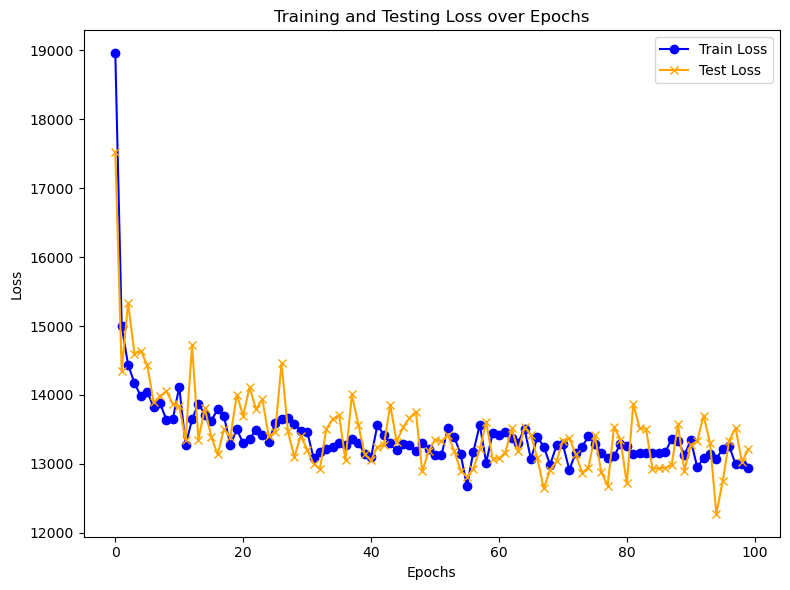

In [11]:
def plot_losses_MO(train_losses, test_losses):
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.plot(train_losses, label='Train Loss', color='blue', linestyle='-', marker='o')
    ax.plot(test_losses, label='Test Loss', color='orange', linestyle='-', marker='x')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epochs')
    ax.set_title('Training and Testing Loss over Epochs')
    ax.legend()
    plt.tight_layout()
    plt.show()
plot_losses_MO(train_losses,test_losses)

# 3 номер

In [13]:
train = MNIST('.MNIST', transform=T.ToTensor(), train=True, download=True)
test = MNIST('.MNIST', transform=T.ToTensor(), train=False, download=True)


In [14]:
class DigitsNN(Module):
    def __init__(self, in_features, num_classes, hide_neurons):
        super(DigitsNN, self).__init__()
        self.model = Sequential() 
        self.model.add(Flatten(start_dim=1))
        self.model.add(Linear(in_features, hide_neurons))
        self.model.add(ReLU())
        self.model.add(Linear(hide_neurons, hide_neurons // 2))
        self.model.add(ReLU())
        self.model.add(Linear(hide_neurons // 2, hide_neurons // 4))
        self.model.add(ReLU())
        self.model.add(Linear(hide_neurons // 4, num_classes))
        self.model.add(LogSoftMax())
        #self.model.add(Flatten(start_dim=1)) 
        
    def forward(self, X):
        return self.model.updateOutput(X)  

    def backward(self, gradOutput):
        return self.model.backward(None, gradOutput)

    def zeroGradParameters(self):
        self.model.zeroGradParameters()

    def getParameters(self):
        return self.model.getParameters()

    def getGradParameters(self):
        return self.model.getGradParameters()

In [15]:
IMG_SIZE = 28
NUM_CLASSES = 10
HIDDEN_SIZE = 64
NUM_EPOCHS = 5
BATCH_SIZE = 32

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model_2 = DigitsNN(in_features=IMG_SIZE ** 2, num_classes=NUM_CLASSES, 
            hide_neurons=HIDDEN_SIZE)

# оптимайзер
config = {'learning_rate': 0.01}
optimizer = sgd 

# функция потерь 
criterion = ClassNLLCriterion()

In [16]:
#train_X = train.data.numpy().reshape(-1, 28 * 28).astype(np.float32) 
#train_Y = train.targets.numpy()

#test_X = test.data.numpy().reshape(-1, 28 * 28).astype(np.float32)  
#test_Y = test.targets.numpy()
train_X = train.data.numpy().astype(np.float32) 
train_Y = train.targets.numpy()

test_X = test.data.numpy().astype(np.float32)  
test_Y = test.targets.numpy()

In [17]:
def plot_losses(train_losses, test_losses, train_acc, test_acc):
    epochs = len(train_losses)
    
    fig, ax1 = plt.subplots(figsize=(10, 5))

    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss', color='tab:red')
    ax1.plot(range(1, epochs + 1), train_losses, 'r-', label='Train Loss')
    ax1.plot(range(1, epochs + 1), test_losses, 'r--', label='Test Loss')
    ax1.tick_params(axis='y', labelcolor='tab:red')

    ax2 = ax1.twinx()
    ax2.set_ylabel('Accuracy', color='tab:blue')
    ax2.plot(range(1, epochs + 1), train_acc, 'b-', label='Train Accuracy')
    ax2.plot(range(1, epochs + 1), test_acc, 'b--', label='Test Accuracy')
    ax2.tick_params(axis='y', labelcolor='tab:blue')

    fig.tight_layout()
    plt.title('Loss and Accuracy')
    plt.legend()
    plt.show()

In [18]:

train_losses, train_acc = [],[]
test_losses, test_acc = [],[]
for epoch in range(NUM_EPOCHS):
    train_loss, train_accuracy = 0, 0
    
    model_2.train() 
    for X_batch, y_batch in get_batches((train_X, train_Y), batch_size=32):
        X_batch = X_batch 
        y_batch = y_batch 
   
        target_one_hot = np.eye(10)[y_batch]  
        model_2.zeroGradParameters()
        logits = model_2.forward(X_batch)  
        loss = criterion.updateOutput(logits, target_one_hot) 
        grad_output = criterion.updateGradInput(logits, target_one_hot)
        model_2.backward(grad_output)
        sgd(model_2.getParameters(), model_2.getGradParameters(), config)
 
        train_loss += loss * X_batch.shape[0] 
        train_accuracy += (np.argmax(logits, axis=1) == y_batch).sum()

    n_train = len(train_X)
    train_loss /= n_train
    train_accuracy /= n_train
    train_losses.append(train_loss)
    train_acc.append(train_accuracy)
    model_2.evaluate()  
    test_loss, test_accuracy = 0, 0
    for X_batch, y_batch in get_batches((test_X, test_Y), batch_size=32):
        X_batch = X_batch  
        y_batch = y_batch  

        target_one_hot = np.eye(10)[y_batch]  

        logits = model_2.forward(X_batch)
        loss = criterion.updateOutput(logits, target_one_hot)
 
        test_loss += loss * X_batch.shape[0]  
        test_accuracy += (np.argmax(logits, axis=1) == y_batch).sum()

    n_test = len(test_X)
    test_loss /= n_test
    test_accuracy /= n_test
    test_losses.append(test_loss)
    test_acc.append(test_accuracy)
    
    
    print(f"Epoch {epoch+1}/{NUM_EPOCHS}, "
          f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    

Epoch 1/5, Train Loss: 0.3422, Train Accuracy: 0.8993, Test Loss: 0.1893, Test Accuracy: 0.9435
Epoch 2/5, Train Loss: 0.1704, Train Accuracy: 0.9498, Test Loss: 0.1442, Test Accuracy: 0.9577
Epoch 3/5, Train Loss: 0.1343, Train Accuracy: 0.9603, Test Loss: 0.1235, Test Accuracy: 0.9637
Epoch 4/5, Train Loss: 0.1143, Train Accuracy: 0.9653, Test Loss: 0.1413, Test Accuracy: 0.9604
Epoch 5/5, Train Loss: 0.1021, Train Accuracy: 0.9695, Test Loss: 0.1161, Test Accuracy: 0.9650


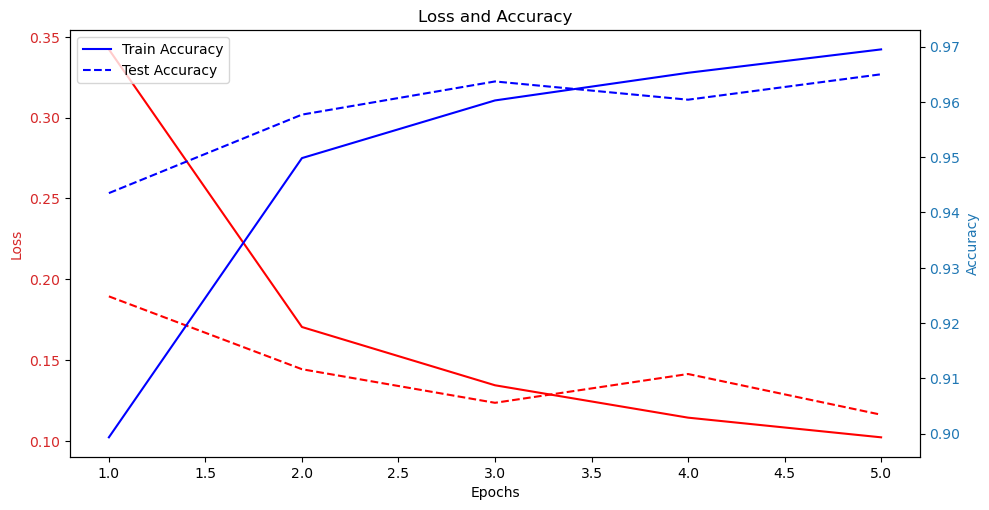

In [19]:
plot_losses(train_losses, test_losses, train_acc, test_acc)

In [20]:
#conv2d не до конца реализован, без него приходится
    